In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import tensorflow  as tf
from tensorflow import keras
#import cupy as cp

from sklearn.preprocessing import normalize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from __future__ import print_function, division
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt

import numpy as np

import sys
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from skimage import filters

import imutils
from sklearn.utils import shuffle

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

Loaded:  (500, 256, 256, 1) (500, 256, 256, 1)


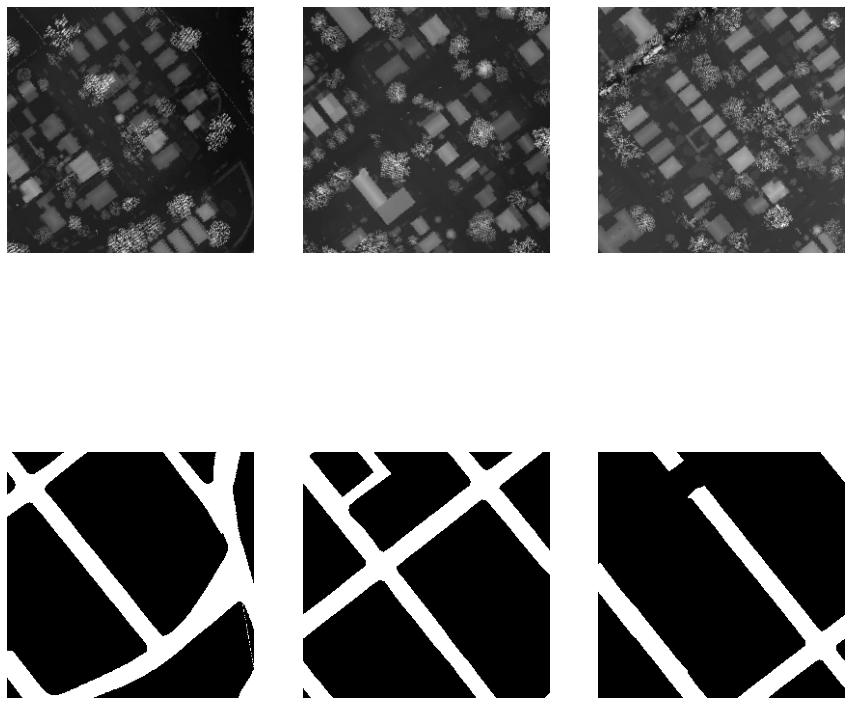

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
skeletons_satellite_data = load('/content/drive/My Drive/lidar/training_lidar_256.npz')
satellite_images, roadbed_images = skeletons_satellite_data['arr_0'], skeletons_satellite_data['arr_1']
print('Loaded: ', satellite_images.shape, roadbed_images.shape)
# plot source images
n_samples = 3
fig = plt.figure(figsize=(15,15))
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(satellite_images[i,:,:,0].astype('uint8'), cmap='gray')
#pyplot.show()
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(roadbed_images[i, :, :, 0].astype('uint8'), cmap='gray')
pyplot.show()

In [ ]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
#from keras.layers import InstanceNormalization
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.losses import BinaryCrossentropy, binary_crossentropy
#from keras_contrib.layers import InstanceNormalization
from keras.callbacks import TensorBoard
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

# define the discriminator model
def define_discriminator(image_shape_d=(256,256,1)):
	image_shape = (256,256,1)
	# weight initialization
	init = RandomNormal(stddev=0.02)
  #z_src = Input(shape=image_shape)
	# source image input
	in_src_image = Input(shape=image_shape)
  #in_merged_src_z = Concatenate()(in_src_image, z_src)
	# target image input
	in_target_image = Input(shape=image_shape_d)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	#d = Conv2D(64, (4,4), strides=2, padding='same', kernel_initializer=init)(merged)
	#d = LeakyReLU(alpha=0.2)(d)
	# C128
	#d = Conv2D(128, (4,4), strides=2, padding='same', kernel_initializer=init)(d)
	#d = BatchNormalization(momentum=0.8)(d)
	#d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=2, padding='same', kernel_initializer=init)(merged)
	#d = BatchNormalization(momentum=0.8)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=2, padding='same', kernel_initializer=init)(d)
	d = BatchNormalization(momentum=0.8)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), strides=2, padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	#print("Patch out - shape", patch_out.shape)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5) # beta_1=0.9, beta_2=0.999, epsilon=1e-08) #beta_1=0.5) # SGD(lr=0.0002, momentum=0.8, name='SGD')
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])#, metrics=['accuracy']) #, loss_weights=[0.5]) #binary_crossentropy BinaryCrossentropy(from_logits=True)
	#print("Discriminator model - shape", model)
	return model

def residual_block(x):
	"""
	Residual block
	"""
	res = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(x)
	res = BatchNormalization(momentum=0.8, epsilon=1e-5)(res)
	res = Activation('relu')(res)

	res = Conv2D(filters=256, kernel_size=3, strides=1, padding="same")(res)
	res = BatchNormalization(momentum=0.8, epsilon=1e-5)(res)
	res = Concatenate()([res,x])
	return res #Add()([res, x])

# define the standalone generator model
def define_generator(image_shape=(256,256,1)):
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	print('Generator in_image: ', in_image.shape)
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	"""
	Create a generator network using the hyperparameter values defined below
	"""
	#input_shape = (256, 256, 3)
	residual_blocks = 9
	#input_layer = Input(shape=input_shape)

	# First Convolution block
	x = Conv2D(filters=64, kernel_size=7, strides=1, padding="same")(in_image)
	x = BatchNormalization(momentum=0.8, epsilon=1e-5)(x) #InstanceNormalization(axis=1)(x)
	x = Activation("relu")(x)

	# 2nd Convolution block
	x = Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
	x = BatchNormalization(momentum=0.8, epsilon=1e-5)(x) #InstanceNormalization(axis=1)(x)
	x = Activation("relu")(x)

	# 3rd Convolution block
	x = Conv2D(filters=256, kernel_size=3, strides=2, padding="same")(x)
	x = BatchNormalization(momentum=0.8, epsilon=1e-5)(x) #InstanceNormalization(axis=1)(x)
	x = Activation("relu")(x)

	# Residual blocks
	for _ in range(residual_blocks):
			x = residual_block(x)

	# Upsampling blocks

	# 1st Upsampling block
	x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
	x = BatchNormalization(momentum=0.8, epsilon=1e-5)(x) #InstanceNormalization(axis=1)(x)
	x = Activation("relu")(x)

	# 2nd Upsampling block
	x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
	x = BatchNormalization(momentum=0.8, epsilon=1e-5)(x) #InstanceNormalization(axis=1)(x)
	x = Activation("relu")(x)

	# Last Convolution layer
	x = Conv2D(filters=1, kernel_size=7, strides=1, padding="same")(x)
	output = Activation('tanh')(x) #tanh
 
	print('Generator output: ', output.shape)
	model = Model(in_image, output)
	return model

	# 17
	#out_image = Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same', activation='tanh')(g)

	# define model
	#model = Model(in_image, out_image)
	#return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	print("define_gan source image - shape", in_src.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	print("define_gan gen_out - shape", gen_out.shape)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	print('dis_out', dis_out.shape)
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5) #, beta_2=0.999, epsilon=1e-08)
	model.compile(loss=['binary_crossentropy','mae'], optimizer=opt, loss_weights=[1,100]) #loss=['binary_crossentropy', 'mae'] mse

	#model.summary()
	#d_model.trainable = True
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 / 127.5) - 1.
	X2 = (X2 / 127.5) - 1.
	#X2 = (X2 * 2) - 1.
	#print('>> X1: ',np.unique(X1))
	#print('>> X2: ',np.unique(X2))
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	#print("trainA - shape", trainA.shape)
	#print("trainB - shape", trainB.shape)
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	#print('real class labels: ', y)
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	#print('fake class labels: ', y)
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot real source images
	fig = plt.figure(figsize=(15,15))
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i,:,:,0], cmap='gray')
		# show title
		pyplot.title(titles[0])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i,:,:,0], cmap='gray')
		# show title
		pyplot.title(titles[1])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i,:,:,0], cmap='gray')
		# show title
		pyplot.title(titles[2])
	# save plot to file
	filename1 = '/content/drive/My Drive/lidar/output/resnet_2_layers_lidar_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/drive/My Drive/lidar/model/resnet_2_layers_lidar_model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history_real_fake(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(2,1,1)
  ax.plot(d1_hist, label='Discriminator Loss - Real')
  ax.plot(d2_hist, label='Discriminator Loss - Fake')
  ax.plot(g_hist, label='Generator Loss')
  # ax.yticks(np.arange(0,101,step=5))
  ax.legend()

  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')

  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(a1_hist, label='Accuracy of Discriminator Loss - Real')
  ax2.plot(a2_hist, label='Accuracy of Discriminator Loss - Fake')
  ax2.set_xlabel('Accuracy')
  ax2.set_ylabel('Loss')
  ax2.legend()
  fig.savefig('/content/drive/My Drive/lidar/plot/d_bce_sigmoid_2_layers_ResNet_lidar_plot_loss.png')

# create a line plot of loss for the gan and save to file
def plot_history_real_fake_log(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(2,1,1)
  ax.plot(d1_hist, label='Discriminator Loss - Real')
  ax.plot(d2_hist, label='Discriminator Loss - Fake')
  ax.plot(g_hist, label='Generator Loss')
  # ax.yticks(np.arange(0,101,step=5))
  ax.legend()
  ax.set_xscale('log')
  ax.set_yscale('log')

  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')

  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(a1_hist, label='Accuracy of Discriminator Loss - Real')
  ax2.plot(a2_hist, label='Accuracy of Discriminator Loss - Fake')
  ax2.set_xlabel('Accuracy')
  ax2.set_ylabel('Loss')
  ax2.legend()
  fig.savefig('/content/drive/My Drive/lidar/plot/d_bce_sigmoid_2_layers_ResNet_lidar_log_plot_loss.png')

# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, a1_hist, a2_hist): #d2_hist
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(2,1,1)
  ax.plot(d_hist, label='Discriminator Loss') #d-real
  #x.plot(d2_hist, label='d-fake')
  ax.plot(g_hist, label='Generator Loss')
  # ax.yticks(np.arange(0,101,step=5))
  ax.legend()
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax2 = fig.add_subplot(2,1,2)
  ax2.plot(a1_hist, label='Accuracy of Discriminator Loss - Real')
  ax2.plot(a2_hist, label='Accuracy of Discriminator Loss - Fake')
  ax2.set_xlabel('Accuracy')
  ax2.set_ylabel('Loss')
  ax2.legend()
  fig.savefig('/content/drive/My Drive/lidar/plot/d_bce_sigmoid_2_layers_ResNet_lidar_plot2_loss.png')

def plot_history_exp(d1_hist, d2_hist, g_hist, a1_hist, a2_hist): 
  fig = plt.figure(figsize=(10,10))
  host = fig.add_subplot(111)

  par1 = host.twinx()
  par2 = host.twinx()

  # host.set_xlim(0, 2)
  # host.set_ylim(0, 2)
  # par1.set_ylim(0, 4)
  # par2.set_ylim(1, 65)

  host.set_xlabel("Epochs")
  host.set_ylabel("Generator Loss")
  par1.set_ylabel("Discriminator Loss - Real")
  par2.set_ylabel("Discriminator Loss - Fake")

  color1 = plt.cm.viridis(0)
  color2 = plt.cm.viridis(0.5)
  color3 = plt.cm.viridis(.9)

  p1, = host.plot(g_hist, color=color1,label="Generator Loss")
  p2, = par1.plot(d1_hist, color=color2, label="Discriminator Loss - Real")
  p3, = par2.plot(d2_hist, color=color3, label="Discriminator Loss - Fake")

  lns = [p1, p2, p3] 
  host.legend(handles=lns, loc='best')

  # right, left, top, bottom
  par2.spines['right'].set_position(('outward', 60))      
  # no x-ticks                 
  par2.xaxis.set_ticks([])
  # Sometimes handy, same for xaxis
  par2.yaxis.set_ticks_position('right')

  host.yaxis.label.set_color(p1.get_color())
  par1.yaxis.label.set_color(p2.get_color())
  par2.yaxis.label.set_color(p3.get_color())
  fig.savefig('/content/drive/My Drive/lidar/plot/d_bce_sigmoid_2_layers_ResNet_lidar_exp_plot_loss.png')
  plt.show()

# train pix2pix models
idx ,d_loss1_array, d_loss2_array, d_loss_array, g_loss_array, a1_array, a2_array = [], [], [], [], [], [], []
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  d_hist, d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list(), list()
	# determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
	#print("n_patch", n_patch)
	# unpack dataset
  trainA, trainB = dataset
	# calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  print("the number of batches per training epoch: ", bat_per_epo)
	# calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  print("the number of training iterations: ", n_steps)

	# manually enumerate epochs
  for i in range(n_steps):
		#d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
		# select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		#print("X_realA shape: ", X_realA.shape)
		#print("X_realB shape: ", X_realB.shape)
		#print("y_real shape: ", y_real.shape)
		# generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		#print("X_fakeB shape: ", X_fakeB.shape)
		#print("y_fake shape: ", y_fake.shape)
		# update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		#print(d_loss1)
		# update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    d_loss = 0.5 * np.add(d_loss1, d_loss2)
		# update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB]) #([imgs_A, imgs_B], [valid, imgs_A])
		
		# summarize performance
    idx.append(i+1)
    d_loss1_array.append(d_loss1)
    d_loss2_array.append(d_loss2)
    d_loss_array.append(d_loss)
    g_loss_array.append(g_loss)
    a1_array.append(int(100*d_loss1))
    a2_array.append(int(100*d_loss2))
    print('>%d, d_real[%.3f] d_fake[%.3f] g[%.3f], a1=%d, a2=%d' % (i+1, d_loss1, d_loss2, g_loss, int(100*d_loss1), int(100*d_loss2)))

		# record history
    d1_hist.append(d_loss1)
    d2_hist.append(d_loss2)
    d_hist.append(d_loss)
    g_hist.append(g_loss)
    a1_hist.append(int(100*d_loss1))
    a2_hist.append(int(100*d_loss2))
		# summarize model performance
		#if (i) % (500) == 0:
    if (i) % (bat_per_epo*10) == 0:
       summarize_performance(i, g_model, dataset)	
	#Save plot history
	#plot_history(d_hist, g_hist, a1_hist, a2_hist) 
  plot_history(d_hist, g_hist, a1_hist, a2_hist) #d1_hist, d2_hist
  plot_history_real_fake(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
  plot_history_real_fake_log(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
  plot_history_exp(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
# load image data
dataset = load_real_samples('/content/drive/My Drive/lidar/training_lidar_256.npz')
print('Loaded: ', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
# image shape for generator (256,256,1):
image_shape = dataset[0].shape[1:]
print("Image shape of generator: ", image_shape)
# image shape for discriminator:
image_shape_d = (256,256,1)
print("Image shape of discriminator: ", image_shape_d)
# define the models
d_model = define_discriminator(image_shape_d)
# summarize the discriminator model
#print("Summary of the discriminator model: ")
#d_model.summary()
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
#print("gan model", gan_model)
# train model
train(d_model, g_model, gan_model, dataset)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
>9266, d_real[0.000] d_fake[0.000] g[35.457], a1=0, a2=0
>9267, d_real[0.000] d_fake[0.000] g[30.114], a1=0, a2=0
>9268, d_real[0.000] d_fake[0.000] g[26.678], a1=0, a2=0
>9269, d_real[0.000] d_fake[0.000] g[37.874], a1=0, a2=0
>9270, d_real[0.000] d_fake[0.000] g[45.640], a1=0, a2=0
>9271, d_real[0.000] d_fake[0.002] g[34.853], a1=0, a2=0
>9272, d_real[0.000] d_fake[0.000] g[22.715], a1=0, a2=0
>9273, d_real[0.000] d_fake[0.000] g[27.102], a1=0, a2=0
>9274, d_real[0.000] d_fake[0.000] g[42.980], a1=0, a2=0
>9275, d_real[0.000] d_fake[0.000] g[45.378], a1=0, a2=0
>9276, d_real[0.001] d_fake[0.000] g[16.718], a1=0, a2=0
>9277, d_real[0.000] d_fake[0.000] g[44.933], a1=0, a2=0
>9278, d_real[0.000] d_fake[0.000] g[41.728], a1=0, a2=0
>9279, d_real[0.000] d_fake[0.000] g[18.904], a1=0, a2=0
>9280, d_real[0.000] d_fake[0.000] g[44.417], a1=0, a2=0
>9281, d_real[0.001] d_fake[0.000] g[16.427], a1=0, a2=0
>9282, d_real[0.000] 

KeyboardInterrupt: ignored

In [ ]:
training_data_file = '/content/drive/My Drive/lidar/log/training_data_2_layers_resnet_mydata.txt'
data = np.array([idx, d_loss1_array, d_loss2_array, d_loss_array, g_loss_array, a1_array, a2_array])
data = data.T
with open(training_data_file, 'w+') as file:
  np.savetxt(file, data, fmt=['%d', '%f', '%f', '%f', '%f', '%d', '%d'])